In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import auc
from sklearn.model_selection import StratifiedKFold
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
cancer = pd.read_csv('HW1/cancer.csv')
cancer.head()

,label,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
0,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [3]:
cancer_y = cancer.label.values
cancer_x = cancer.loc[:, '1':'30'].values
cancer_features = cancer.drop(['label'], axis=1).columns.values

In [4]:
cancer_y = np.asarray([1 if y == 'M' else 0 for y in cancer_y])

In [5]:
spam = pd.read_csv('HW1/spam.csv')
spam.head()

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,char_freq_:,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total,label
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278,1
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1


In [6]:
spam_y = spam.label.values
spam_x = spam.loc[:, 'word_freq_make':'capital_run_length_total'].values
spam_features = spam.drop(['label'], axis=1).columns.values

# Реализация RandomForest

In [7]:
def tree_builder(x, y, features, metrics, depth, max_depth, rules, idx, N):
    lbls, counts = np.unique(y, return_counts=True)
    if len(lbls) == 1:
        rules[idx] = [0, 0]
        rules[idx][lbls[0]] = 1
        return
    if depth == max_depth:
        rules[idx] = [0, 0] 
        rules[idx][lbls[0]] = counts[0] / len(y)
        rules[idx][lbls[1]] = counts[1] / len(y)
        return
    
    best_params = -1
    best_metric = -1
    best_column = -1
    splits = [[], []]
    n = x.shape[0]
    
    for i in features:
        col_sorted, idx_sorted = zip(*sorted(zip(x[:, i], 
                                                 range(n))))
        min_, max_ = col_sorted[0], col_sorted[n - 1]
        thresholds = [np.unique(col_sorted)[i] 
                      for i in np.linspace(0, len(np.unique(col_sorted)) - 1, 30, dtype=int)]
        col_idx = 0
        
        for j in range(30):
            while col_idx + 1 < n and col_sorted[col_idx + 1] <= thresholds[j]:
                col_idx += 1
            
            left = [y[i] for i in idx_sorted[:col_idx + 1]]
            right = [y[i] for i in idx_sorted[col_idx + 1:]]
            
            if left == [] or right == []:
                continue
                
            score = metrics(y, left, right, N)
            if score  > best_metric:
                best_params = thresholds[j]
                best_metric = score
                best_column = i
                splits[0], splits[1] = idx_sorted[:col_idx + 1], idx_sorted[col_idx + 1:]
                
    if best_metric == -1:
        rules[idx] = [0, 0] 
        rules[idx][lbls[0]] = counts[0] / len(y)
        rules[idx][lbls[1]] = counts[1] / len(y)
        return
    
    rules[idx] = [best_params, best_column,
                  2 * idx, 2 * idx + 1, 0, 0]
    rules[idx][4 + lbls[0]] = counts[0] / len(y)
    rules[idx][4 + lbls[1]] = counts[1] / len(y)
    
    tree_builder(x[splits[0], :], [y[i] for i in splits[0]], features, metrics, depth + 1, 
                 max_depth, rules, 2 * idx, N)
    tree_builder(x[splits[1], :], [y[i] for i in splits[1]], features, metrics, depth + 1, 
                 max_depth, rules, 2 * idx + 1, N)
    
    """
    [thr, col, <_idx, >_idx, label0, label1]
    or
    [lbl0, lbl1]
    """     

In [8]:
def gini_impurity(y, left, right, N):
    
    def __g(arr):
        lbls, counts = np.unique(arr, return_counts=True)
        res = 1 / (len(arr) ** 2)
        for c in counts:
            res *= c
        return res * 2
    
    node = len(y) / N * __g(y)
    l = len(left) / N * __g(left)
    r = len(right) / N * __g(right)
    
    return node - l - r

In [9]:
def tree_traversal(x, tree, max_depth):
    curr_depth = 0
    r_idx = 1
    curr_d = 0
    while len(tree[r_idx]) > 2 and curr_depth < max_depth:
        if x[tree[r_idx][1]] > tree[r_idx][0]:
            r_idx = tree[r_idx][3]
        else:
            r_idx = tree[r_idx][2]
        curr_d += 1
    if len(tree[r_idx]) == 2:
        return tree[r_idx]
    else:
        return tree[4:]

In [10]:
def RandomForest(x, y, n_trees, max_depth):
    trees = []
    N, M = x.shape
    
    for _ in range(n_trees):
        x_idx = np.random.choice(N, N, replace=True)
        features = np.random.choice(M, int(np.sqrt(M)) + 1, replace=False)
        
        rules = [0 for _ in range(2 ** (max_depth + 1))]
        tree_builder(x[x_idx, :], [y[i] for i in x_idx], features, metrics=gini_impurity, depth=0,
                     max_depth=max_depth, rules=rules, idx=1, N=N)
        
        trees.append(rules)
        
    return trees

In [11]:
def rf_predict(x, rf, max_depth):
    predictions = [0, 0]
    for tree in rf:
        p = tree_traversal(x, tree, max_depth)
        predictions[0] += p[0]
        predictions[1] += p[1]
    
    return [predictions[0] / len(rf), predictions[1] / len(rf)]

In [12]:
def count_auc(x, y, max_depth, rf):
    preds = np.zeros((x.shape[0], 2))
    n_pos = sum([1 if y_ == 1 else 0 for y_ in y])
    n_neg = x.shape[0] - n_pos
    
    for i in range(x.shape[0]):
        pred = rf_predict(x[i,:], rf, max_depth)
        preds[i, :] = pred
    
    thr = np.linspace(0, 1, 30)
    tp_fp = np.zeros((30, 2))
    for i in range(30):
        for j in range(x.shape[0]):
            if y[j] == 1 and preds[j, 1] >= thr[i]:
                tp_fp[i, 0] += 1
            elif y[j] != 1 and preds[j, 1] >= thr[i]:
                tp_fp[i, 1] += 1
            
    tp_fp[:, 0] /= n_pos
    tp_fp[:, 1] /= n_neg
    return auc(tp_fp[:, 1], tp_fp[:, 0]), tp_fp

In [19]:
def plot_roc(auc_, tp_fp, max_depth, n_trees, dataset, metric):
    print(f'Датасет: {dataset}\n'
          f'Функция impurity: {metric}\n'
          f'Глубина дерева: {max_depth}\n'
          f'Число деревьев: {n_trees}\n'
          f'ROC-AUC: {auc_}')
    if isinstance(tp_fp, list):
        for tf in tp_fp:
            plt.plot(tf[:, 1], tf[:, 0])
        plt.legend([f'Fold {i}' for i in range(len(tp_fp))])
        plt.title('roc-кривые для каждой \nкроссвалидационной подвыборки')
    else:
        plt.plot(tp_fp[:, 1], tp_fp[:, 0])
        plt.title('roc-кривая')
    plt.show()

In [62]:
cancer_rf = RandomForest(cancer_x, cancer_y, max_depth=3, n_trees=20)

Датасет: cancer
Функция impurity: gini
Глубина дерева: 3
Число деревьев: 20
ROC-AUC: 0.9954746049363141


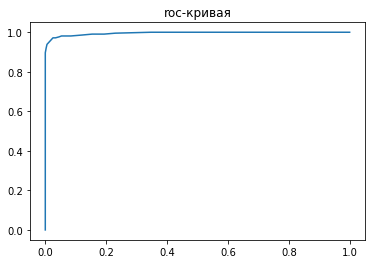

In [102]:
plot_roc(*count_auc(cancer_x, cancer_y, 3, cancer_rf), 3, 20, 'cancer', 'gini')

In [71]:
spam_rf = RandomForest(spam_x, spam_y, max_depth=3, n_trees=20)

Датасет: spam
Функция impurity: gini
Глубина дерева: 3
Число деревьев: 20
ROC-AUC: 0.964913058169873


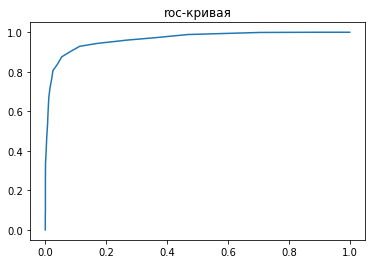

In [72]:
plot_roc(spam_x, spam_y, 'spam', 3, spam_rf, 'gini')

# Оптимизация параметров на кроссвалидации

In [14]:
def cross_val_rf(x, y, n_trees_params, max_depth_params, dataset, n_folds=5):
    scores = {}
    for n_trees in n_trees_params:
        for max_depth in max_depth_params:
            scores[(n_trees, max_depth)] = [0, [[] for _ in range(n_folds)]]
            
    max_depth, n_trees = max(max_depth_params), max(n_trees_params)
    
    skf = StratifiedKFold(n_splits=n_folds, shuffle=True)
    n = 0
    for train_idx, validate_idx in skf.split(x, y):
        max_rf = RandomForest(x[train_idx], y[train_idx], max_depth=max_depth, n_trees=n_trees)
#         print(max_rf)
        
        for n_trees_p in n_trees_params:
            for max_depth_p in max_depth_params:
                auc_, tp_fp = count_auc(x[validate_idx], y[validate_idx], max_depth_p,
                                        max_rf[:n_trees_p])
                scores[(n_trees_p, max_depth_p)][0] += auc_
                scores[(n_trees_p, max_depth_p)][1][n] = tp_fp
                
        n += 1
                
    max_score = 0
    best_params = ()
    
    for k, v in scores.items():
        if v[0] > max_score:
            max_score = v[0]
            best_params = k
            
    print(f'Датасет: {dataset}\n'
          f'Лучшие параметры для RandomForest: \n'
          f'\tчисло деревьев - {best_params[0]}, максимальная глубина - {best_params[1]}\n'
          f'Среднее значение auc: {(max_score / n_folds)}')
    
    return max_score / n_folds, scores[best_params][1]

In [15]:
cancer_auc, cancer_tpfps = cross_val_rf(cancer_x, cancer_y,
                                        n_trees_params=[5, 10, 20, 30, 50, 100], 
                                        max_depth_params=[2, 3, 5, 7, 10], dataset='cancer')

Датасет: cancer
Лучшие параметры для RandomForest: 
	число деревьев - 100, максимальная глубина - 2
Среднее значение auc: 0.9898584660417284


Датасет: cancer
Функция impurity: gini
Глубина дерева: 2
Число деревьев: 100
ROC-AUC: 0.9898584660417284


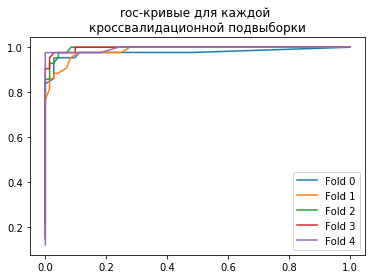

In [21]:
plot_roc(cancer_auc, cancer_tpfps, 2, 100, 'cancer', 'gini')

In [22]:
spam_auc, spam_tpfps = cross_val_rf(spam_x, spam_y,
                                        n_trees_params=[5, 10, 20, 30, 50, 100], 
                                        max_depth_params=[2, 3, 5, 7, 10], dataset='spam')

Датасет: spam
Лучшие параметры для RandomForest: 
	число деревьев - 100, максимальная глубина - 2
Среднее значение auc: 0.976621782563584


Датасет: spam
Функция impurity: gini
Глубина дерева: 2
Число деревьев: 100
ROC-AUC: 0.976621782563584


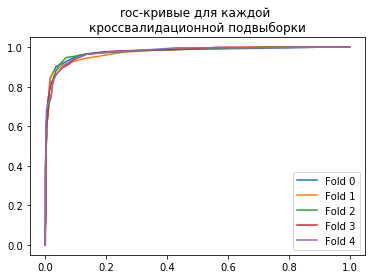

In [23]:
plot_roc(spam_auc, spam_tpfps, 2, 100, 'spam', 'gini')